# **Diamond Price Prediction**

### Frame the problem:
* The problem requires Supervised Learning. 
* The instances come with an expected output (i.e the diamond's price).
* Predicting the price(numerical) of a diamond from dataset is a Regression Task. More specifically, a Multivariate Regression Task.

### Import libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # Python plotting library
import seaborn as sns # More snazzy plotting library
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV   
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from pprint import pprint

**Importing train data**

In [3]:
# reads the csv and creates the dataframe called train_df
train_df = pd.read_csv('https://raw.githubusercontent.com/OLA333/Diamond-Price-Prediction/main/train.csv')

In [4]:
# Show first 5 rows of the data
train_df.head()

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


In [ ]:
# Show data shape (# rows, # columns)
train_df.shape

(43152, 11)

## Data Preparation

**Data Preprocessing**

In [5]:
# Detect data-type of each feature, besides whether having null vlues or not
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       43152 non-null  int64  
 1   carat    43152 non-null  float64
 2   cut      43152 non-null  object 
 3   color    43152 non-null  object 
 4   clarity  43152 non-null  object 
 5   depth    43152 non-null  float64
 6   table    43152 non-null  float64
 7   price    43152 non-null  int64  
 8   x        43152 non-null  float64
 9   y        43152 non-null  float64
 10  z        43152 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


* Observe having cetegorical predictors
* Having no null values

In [6]:
# Look at the summary of the numerical attributes
train_df.describe()

,Id,carat,depth,table,price,x,y,z
count,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
mean,21576.500000,0.797855,61.747177,57.458347,3929.491912,5.731568,5.735018,3.538568
std,12457.053745,0.473594,1.435454,2.233904,3985.527795,1.121279,1.148809,0.708238
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,10788.750000,0.400000,61.000000,56.000000,947.750000,4.710000,4.720000,2.910000
50%,21576.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,32364.250000,1.040000,62.500000,59.000000,5312.000000,6.540000,6.540000,4.040000
max,43152.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Min value of "x", "y", "z" are zero. This indicates that there are faulty values in data that represents dimensionless or 2-dimensional diamonds, as it doesn’t make any sense to have length\width\depth of a diamond to be zero. So we need to filter out those as it clearly faulty data points.

In [7]:
#Dropping dimentionless diamonds
train_df = train_df[(train_df[['x','y','z']] != 0).all(axis=1)]
train_df.shape

(43135, 11)

*We had at the start 43152 diamonds, now we have 43135. It means that we "lost" only 17 diamonds.*

In [8]:
# Null values check
train_df.isnull().mean()

Id         0.0
carat      0.0
cut        0.0
color      0.0
clarity    0.0
depth      0.0
table      0.0
price      0.0
x          0.0
y          0.0
z          0.0
dtype: float64

*No Null values in train and test datasets*

In [9]:
# Check for duplicated rows
train_df.duplicated().sum()

0

*No duplicated data*

## EDA

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0cbece6050>,
      dtype=object)

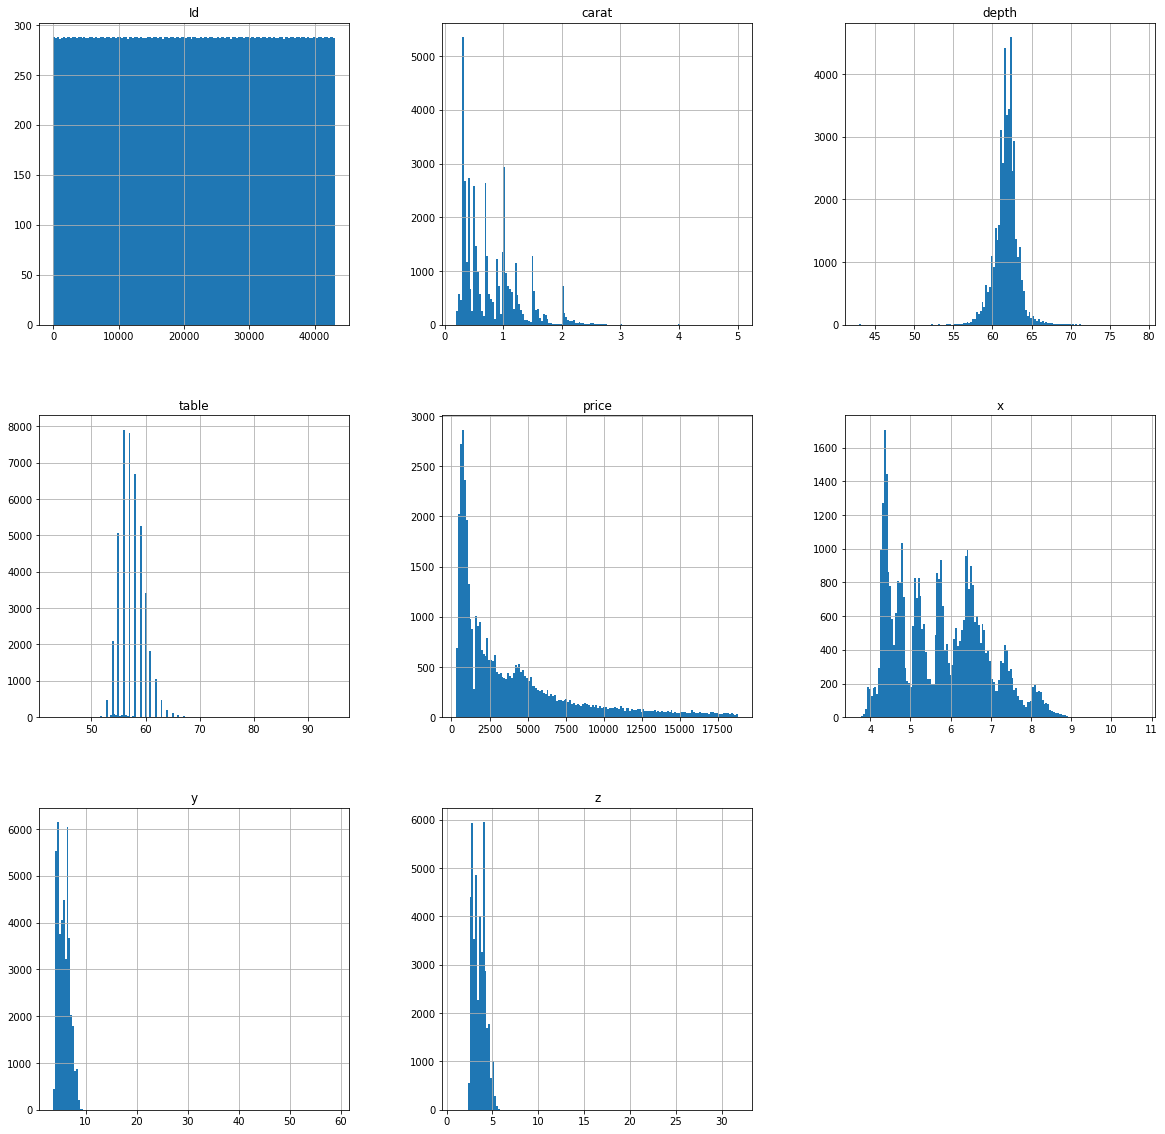

In [10]:
# Observe the distribution of the features
train_df.hist(figsize = (20,20),bins=150)

* Observe that 'Id' feature has uniform distribution, therefore we'll drop it, as its p-value is almost=1, besides It's a ratio data with just sequential numbers that has no relationship with any other feature and won't affect their results
* Z and y features are confined to a certain small range
* 'price', 'carat', and 'x' features are right skewed, as they're decreasing over time
* 'carat' feature has a spike in a certain value, that may be 0.35
* Most diamonds are roughly between 0.3 and 1.5 Carats.

In [11]:
df = train_df.drop(['carat','price','Id'], 1)
df

,cut,color,clarity,depth,table,x,y,z
0,Ideal,I,SI2,61.8,57.0,6.57,6.60,4.07
1,Premium,G,VVS2,60.9,58.0,7.38,7.42,4.51
2,Ideal,F,VS2,61.3,56.0,4.43,4.41,2.71
3,Ideal,G,VS2,61.2,56.0,5.19,5.22,3.19
4,Premium,H,VVS2,61.0,57.0,5.76,5.72,3.50
...,...,...,...,...,...,...,...,...
43147,Ideal,E,VS2,61.5,56.0,5.16,5.18,3.18
43148,Very Good,D,VS2,62.1,59.0,5.70,5.73,3.55
43149,Premium,I,VVS1,61.5,58.0,4.95,4.87,3.02
43150,Premium,E,VS1,60.2,58.0,4.38,4.43,2.65


In [12]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'brown', 'pink']
colors

['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'brown', 'pink']

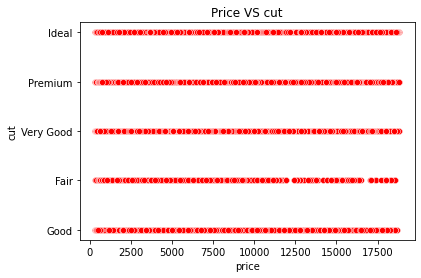

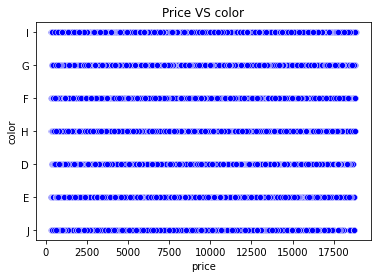

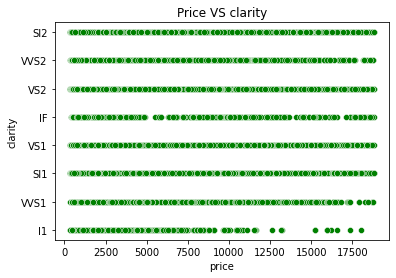

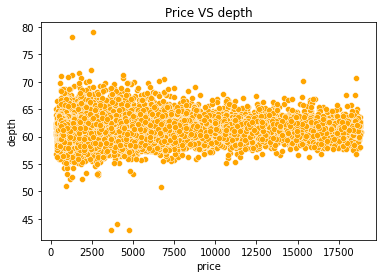

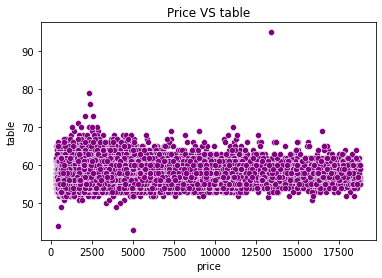

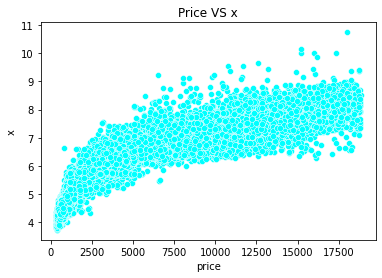

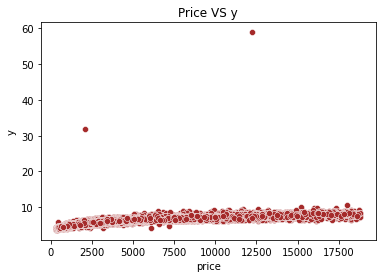

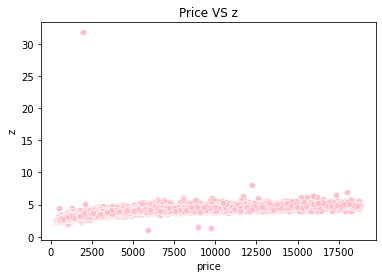

In [13]:
for col,color in zip(df, colors):
    sns.scatterplot(x=train_df.price, y=train_df[col], color=color)
    plt.title(f"Price VS {col}")
    plt.show()    

price has linear relation with x

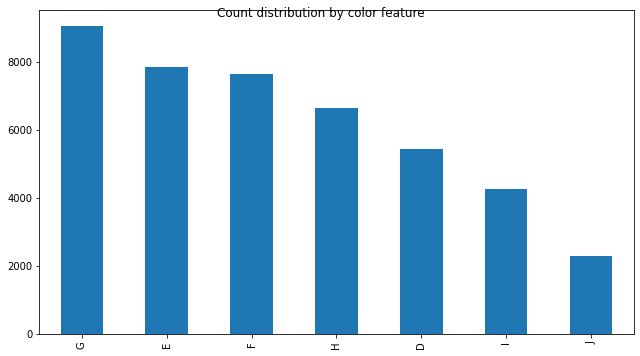

In [14]:
# Sorted
fig= plt.figure(figsize=(9,5))

fig.suptitle("Count distribution by color feature")
train_df['color'].value_counts().plot.bar()
plt.tight_layout()

Colors (G,E,F ) are more widespread in dataset


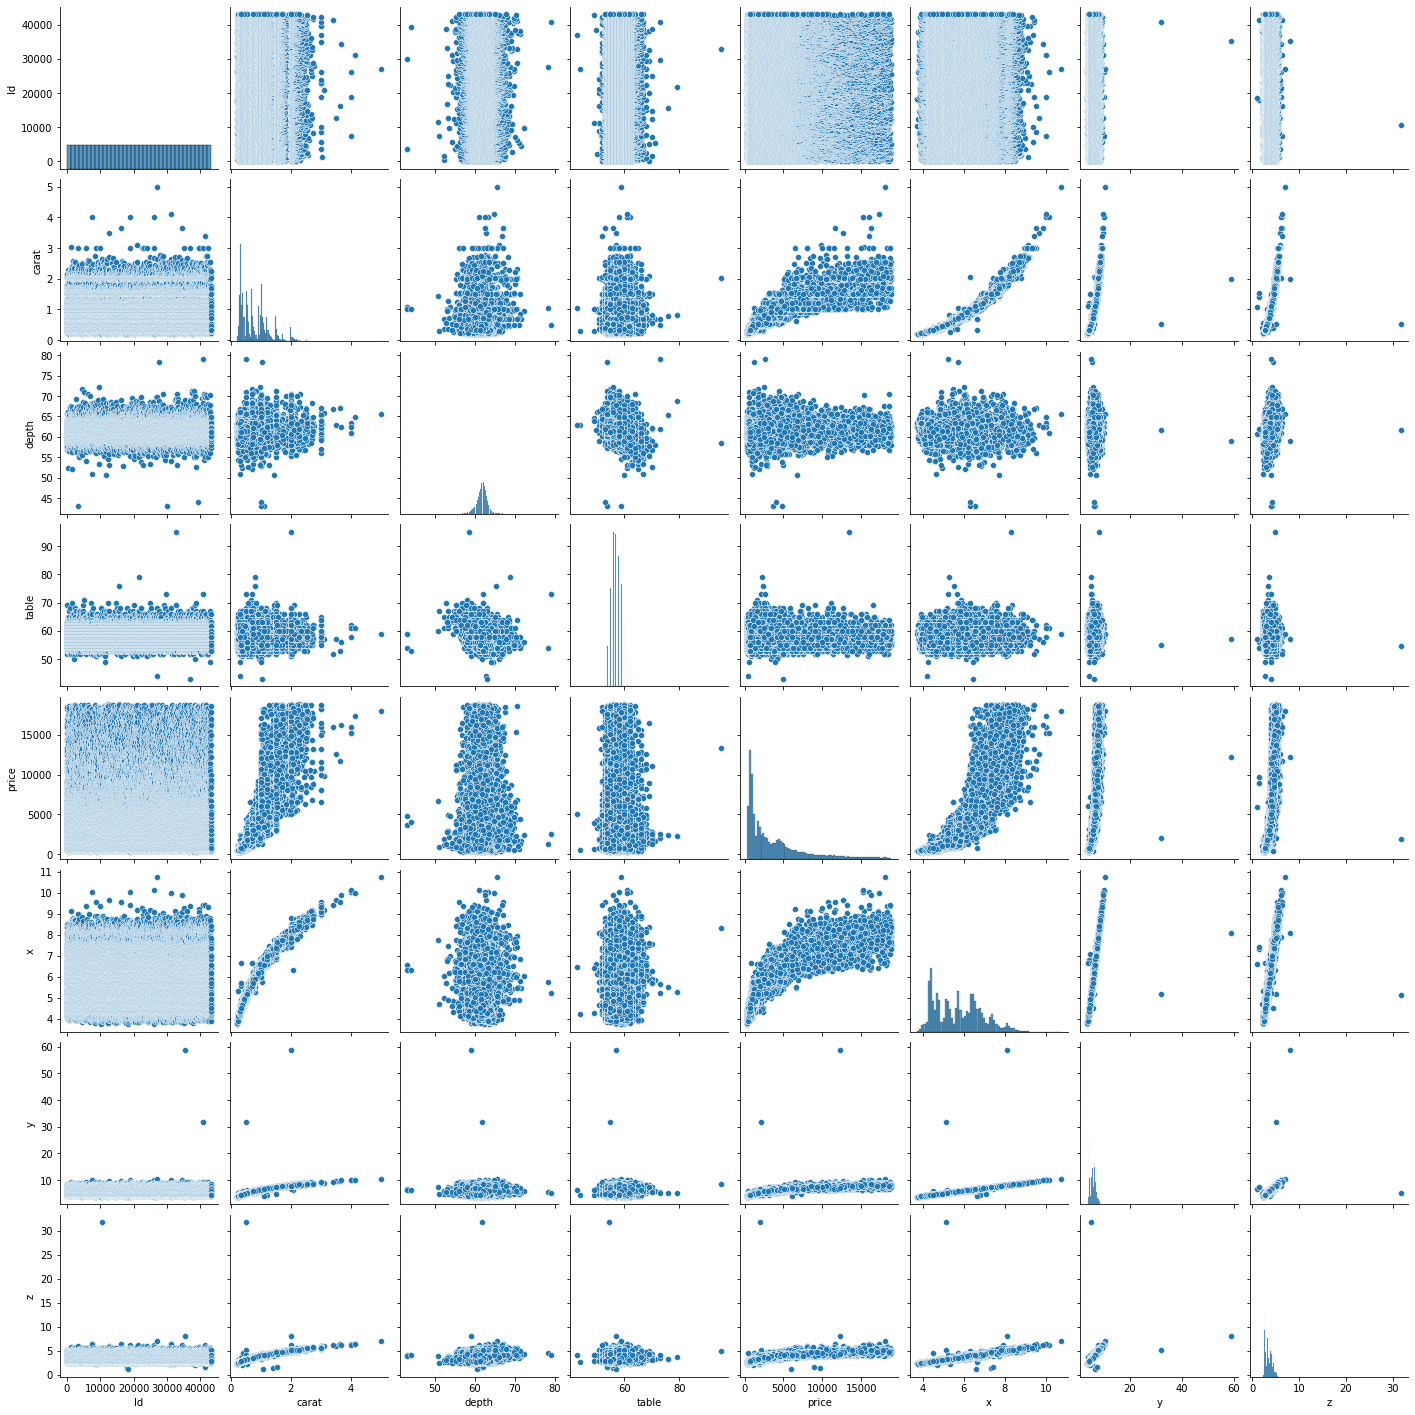

In [15]:
# Observe correlaiton between numerical features. Pay attention to spotting outliers 
sns.pairplot(data=train_df)
plt.show()

price has linear relationship with carat


'carat', 'x', 'y', and 'z' are positive correlated with each other, with 3-4 outliers

Plot a Pair-plot of Price vs. 4 Cs (Carat, Cut, Color, Clarity) — the most popular and marketed properties of a diamond.

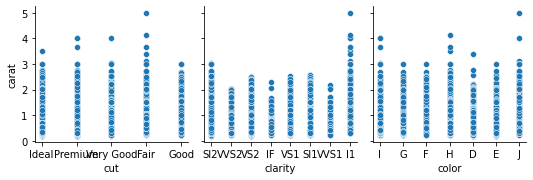

In [32]:
# plot carat vs other Cs
sns.pairplot(train_df, x_vars=['cut', 'clarity', 'color'], y_vars = ['carat'])
plt.show()

The biggest diamond (higher carat) fall in Fair cut, I1 clarity and H-I color

In [33]:
train_df['color'].value_counts()

G    9053
E    7832
F    7630
H    6645
D    5421
I    4264
J    2290
Name: color, dtype: int64

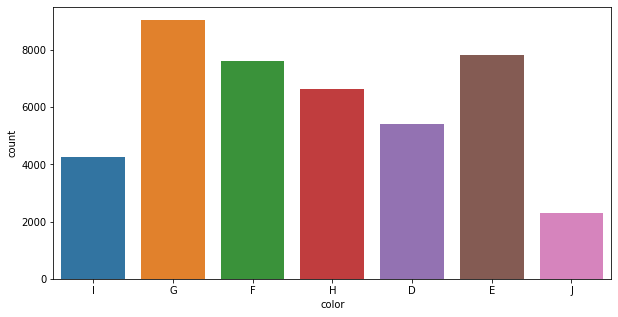

In [34]:
plt.figure(figsize = (10,5))
sns.countplot(x = train_df['color'])

Colors (G,E,F ) are more widespread in dataset






In [18]:
train_df['cut'].value_counts()

Ideal        17201
Premium      11103
Very Good     9657
Good          3878
Fair          1296
Name: cut, dtype: int64

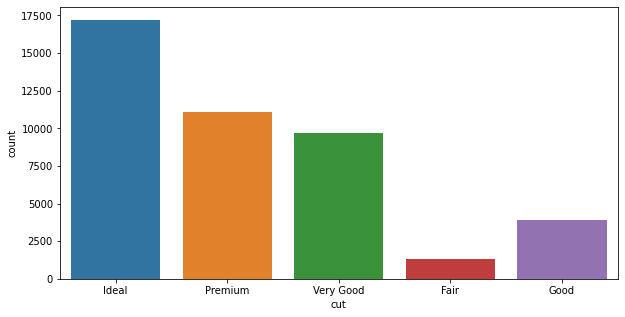

In [19]:
plt.figure(figsize = (10,5))
sns.countplot(x = train_df['cut'])

Cut (Ideal )has the greatest  widespread in dataset   

In [20]:
train_df['clarity'].value_counts()

SI1     10426
VS2      9821
SI2      7424
VS1      6474
VVS2     4041
VVS1     2904
IF       1442
I1        603
Name: clarity, dtype: int64

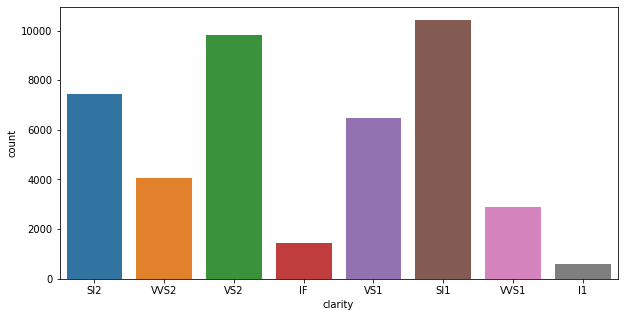

In [21]:
plt.figure(figsize = (10,5))
sns.countplot(x = train_df['clarity'])

Clarity (SI1 ,VS2 ,SI2 ) are more widespread in dataset 

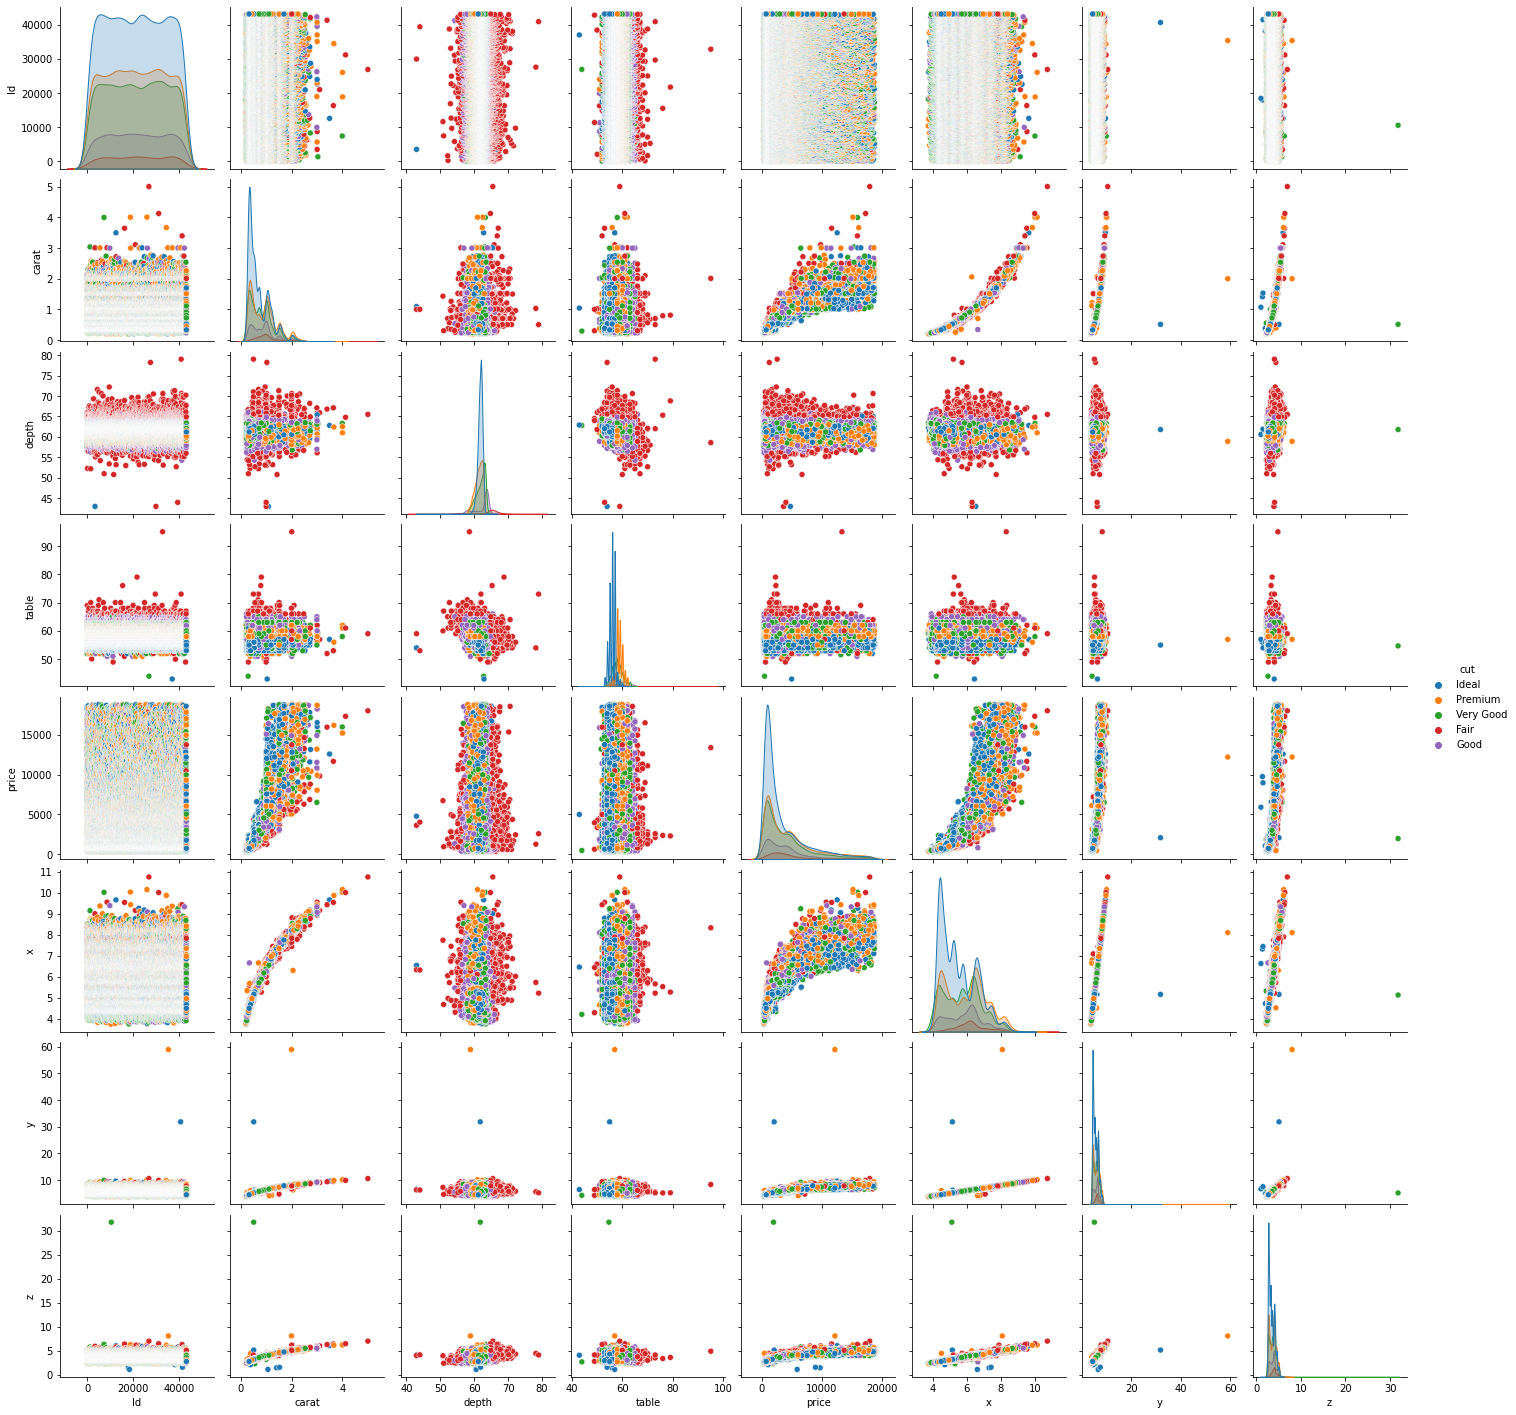

In [22]:
sns.pairplot(train_df, hue= "cut")

Carat has linear relation with price

In [23]:
num_cols_train = train_df.select_dtypes(exclude='object').columns.to_list()   
num_cols_train

['Id', 'carat', 'depth', 'table', 'price', 'x', 'y', 'z']

In [36]:
def handle_outliers(col, data_df):
    Q1 = col.quantile(0.25)                   
    Q3 = col.quantile(0.75)                  
    IQR = Q3 - Q1                
    idx = ~( (col < (Q1 - 1.5 * IQR)) | (col > (Q3 + 1.5 * IQR)) )           
    return data_df[idx]
for col in num_cols_train:
    train_clean = handle_outliers(train_df[col], train_df)

In [35]:
train_df.shape

(43135, 11)

In [26]:
train_clean.shape

(43113, 11)

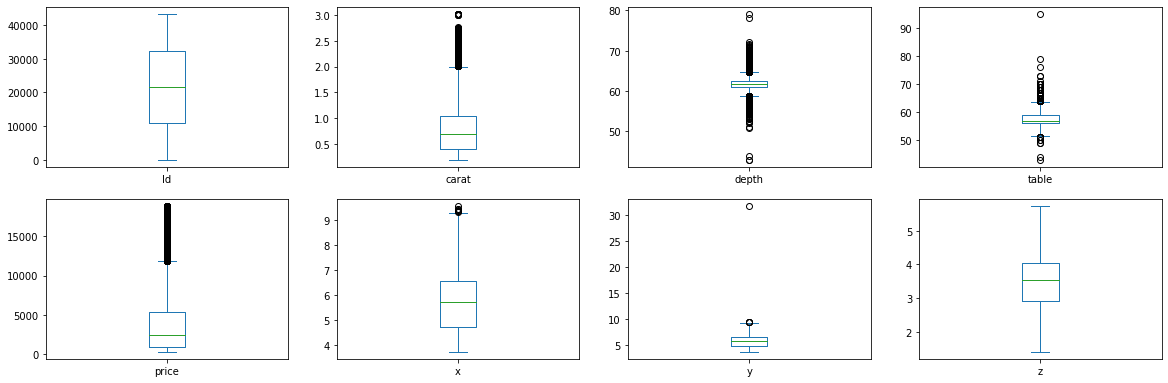

In [27]:
train_clean.plot(kind='box',figsize=(20,10),subplots=True,layout=(3,4))
plt.show()

In [28]:
train_clean = train_clean[(train_clean["depth"]<75)&(train_clean["depth"]>45)]
train_clean = train_clean[(train_clean["table"]<80)&(train_clean["table"]>40)]

In [29]:
train_clean.shape

(43107, 11)

In [30]:
train_clean

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50
...,...,...,...,...,...,...,...,...,...,...,...
43147,43148,0.52,Ideal,E,VS2,61.5,56.0,1760,5.16,5.18,3.18
43148,43149,0.72,Very Good,D,VS2,62.1,59.0,3016,5.70,5.73,3.55
43149,43150,0.44,Premium,I,VVS1,61.5,58.0,990,4.95,4.87,3.02
43150,43151,0.31,Premium,E,VS1,60.2,58.0,734,4.38,4.43,2.65


In [37]:
def histplot(df, listvar):
    fig, axes = plt.subplots(nrows=1, ncols=len(listvar), figsize=(20, 3))
    counter=0
    for ax in axes:
        df.hist(column=listvar[counter], bins=20, ax=axes[counter])
        plt.ylabel('Price')
        plt.xlabel(listvar[counter])
        counter = counter+1
    plt.show()

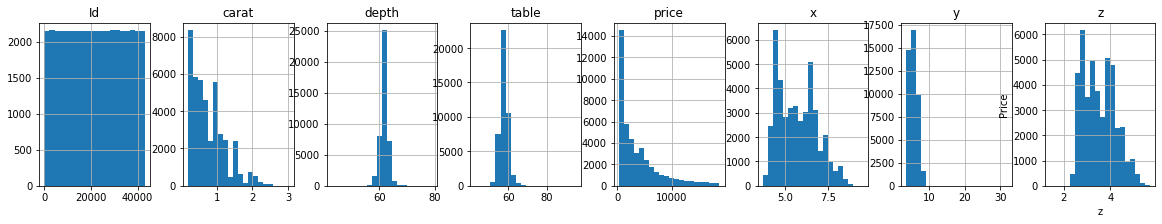

In [38]:
histplot(train_clean, num_cols_train)

In [ ]:
# As most properties are not normally distributed, we need to apply log transformation 
def convertfeatures2log(df, num_cols_train):
    for var in num_cols_train:
        train_clean[var] = np.log(train_clean[var])

convertfeatures2log(train_clean, num_cols_train)
histplot(train_clean, num_cols_train)
#train_clean.hist(figsize = (20,20),bins=150)

In [39]:
train_clean

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50
...,...,...,...,...,...,...,...,...,...,...,...
43147,43148,0.52,Ideal,E,VS2,61.5,56.0,1760,5.16,5.18,3.18
43148,43149,0.72,Very Good,D,VS2,62.1,59.0,3016,5.70,5.73,3.55
43149,43150,0.44,Premium,I,VVS1,61.5,58.0,990,4.95,4.87,3.02
43150,43151,0.31,Premium,E,VS1,60.2,58.0,734,4.38,4.43,2.65


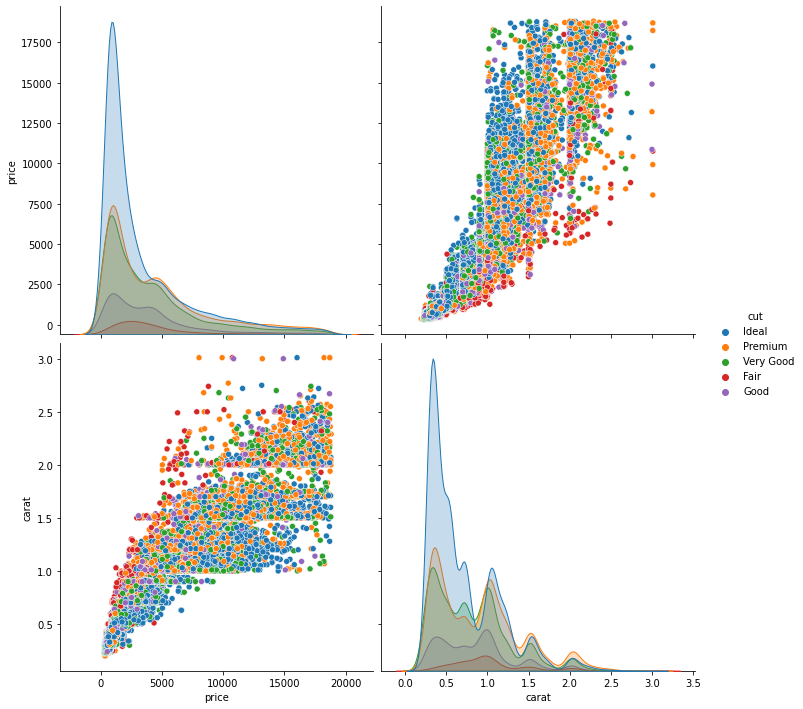

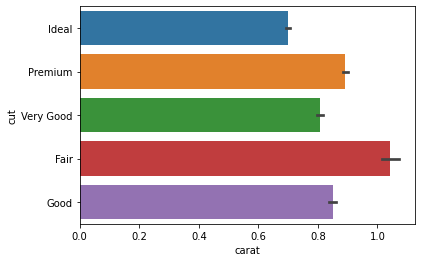

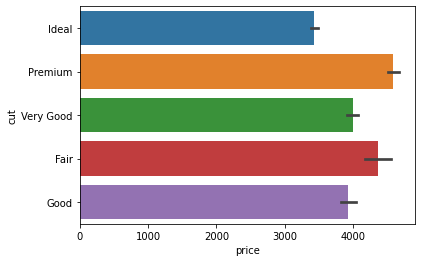

In [40]:

sns.pairplot(train_clean[["price", "carat", "cut"]], hue = "cut", height = 5)
plt.show()
sns.barplot(x = "carat", y = "cut", data = train_df)
plt.show()
sns.barplot(x = "price", y = "cut", data = train_df)
plt.show()

## Encoding categorical predictors
##### A crucial transformation step in data preprocessing should be done, as scikit-learn accepts only numerical features

## Apply label encoder to each column with categorical data (color,cut,clarity) 

In [44]:
cat_cols_train = train_clean.select_dtypes(include='object').columns.to_list()  

In [45]:
cat_cols_train   


['cut', 'color', 'clarity']

In [42]:
for i in cat_cols_train:
    print(train_clean[i].unique())

['Ideal' 'Premium' 'Very Good' 'Fair' 'Good']
['I' 'G' 'F' 'H' 'D' 'E' 'J']
['SI2' 'VVS2' 'VS2' 'IF' 'VS1' 'SI1' 'VVS1' 'I1']


In [46]:
def categoricals_label_encoder(train_clean, cat_cols_train):
    # Make copy to avoid changing original data 
    train_label = train_clean.copy()

    # Apply label encoder to each column with categorical data
    label_encoder = LabelEncoder()

    for col in cat_cols_train:
        train_label[col] = label_encoder.fit_transform(train_label[col]) 
        
    return train_label

In [49]:
# categoricals_label_encoder(data, categorical_columns_names)
train_label = categoricals_label_encoder(train_clean, cat_cols_train)

train_label.head()

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,2,5,3,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,3,3,7,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,2,2,5,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,2,3,5,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,3,4,7,61.0,57.0,2596,5.76,5.72,3.50


In [ ]:
for i in cat_cols_train:
    print(train_label[i].unique())

[2 3 4 0 1]
[5 3 2 4 0 1 6]
[3 7 5 1 4 2 6 0]


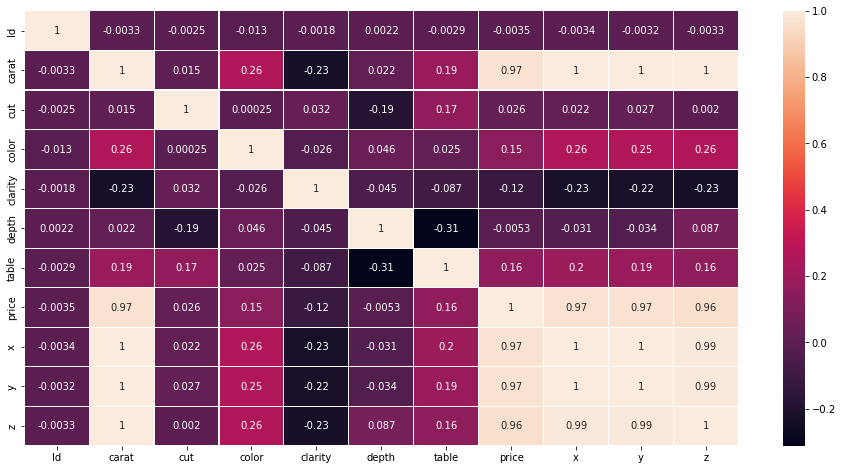

In [ ]:
#correlation matrix

plt.figure(figsize=(16, 8))
sns.heatmap(train_label.corr(), annot=True, linewidths=0.05)

* "depth", "cut" and "table" show low correlation. 
* As expected from pairplot, 'carat', 'x', 'y', and 'z' are highly positive correlated with each other. 
  As well their strong positive correlation with target variable(price)
* 'table' and 'carat' has low correlaiton with target variable(price)
* As expected, 'Id' has no correlaiton with any feature,as it has a uniform dstribution
#### Since 'carat' has the strongest correlation with 'price', we use this feature for our Stratified Sampling.

In [50]:
train_label.groupby(['depth'])['price'].value_counts(normalize=True)

depth  price
43.0   3634     0.5
       4778     0.5
44.0   4032     1.0
50.8   6727     1.0
51.0   945      1.0
               ... 
71.3   4368     1.0
71.6   1696     1.0
72.2   2438     1.0
78.2   1262     1.0
79.0   2579     1.0
Name: price, Length: 36861, dtype: float64

In [51]:
train_label.groupby(['table'])['price'].value_counts(normalize=True)

table  price
43.0   4997     1.0
44.0   474      1.0
49.0   630      0.5
       3951     0.5
50.0   4227     1.0
               ... 
73.0   2100     0.5
       2579     0.5
76.0   2362     1.0
79.0   2301     1.0
95.0   13387    1.0
Name: price, Length: 26997, dtype: float64

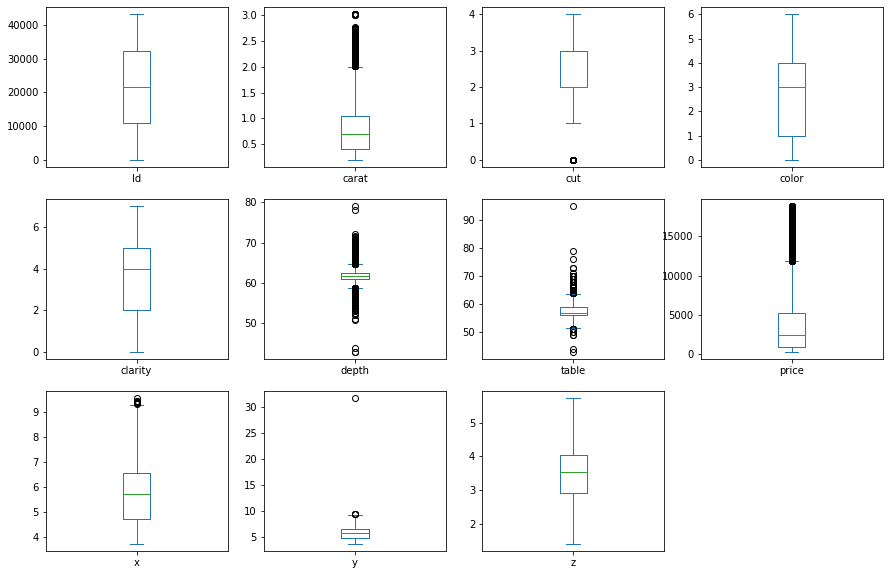

In [52]:
train_label.plot(kind='box',figsize=(15,10),subplots=True,layout=(3,4))
plt.show()

## Feature Engineering

####  Create New Feature 'Volume'
Because the diamond dimensions - x,y and z are correlated to each other (We have also seen it in the correlation matrix) , so we can replace these 3 features with one single feature -VOLUME. So lets add volume feature and drop the x,y and z features.

In [53]:
train_label['volume'] = train_label['x']*train_label['y']*train_label['z']
train_label.head()

,Id,carat,cut,color,clarity,depth,table,price,x,y,z,volume
0,1,1.06,2,5,3,61.8,57.0,4270,6.57,6.60,4.07,176.483340
1,2,1.51,3,3,7,60.9,58.0,15164,7.38,7.42,4.51,246.965796
2,3,0.32,2,2,5,61.3,56.0,828,4.43,4.41,2.71,52.943373
3,4,0.53,2,3,5,61.2,56.0,1577,5.19,5.22,3.19,86.422842
4,5,0.70,3,4,7,61.0,57.0,2596,5.76,5.72,3.50,115.315200


(0.0, 50000.0)

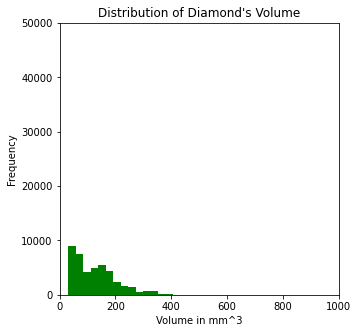

In [54]:
plt.figure(figsize=(5,5))
plt.hist( x=train_label['volume'] , bins=30 ,color='g')
plt.xlabel('Volume in mm^3')
plt.ylabel('Frequency')
plt.title('Distribution of Diamond\'s Volume')
plt.xlim(0,1000)
plt.ylim(0,50000)

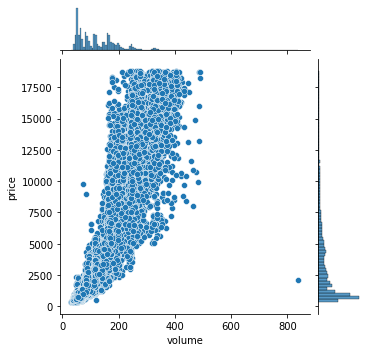

In [55]:
sns.jointplot(x='volume', y='price' , data=train_label, size=5)

In [56]:
train_label.drop(['x','y','z'], axis=1, inplace= True)

In [57]:
#train_label.columns
train_columns = train_label.columns
train_columns

Index(['Id', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price',
       'volume'],
      dtype='object')

## Feature Scaling

###### Use Standardization, as It's much less affected by outliers than normalization

In [ ]:
scale = StandardScaler()
train_label = scale.fit_transform(train_label) 
train_label

array([[-9.68087441,  0.7782307 , -0.54176958, ..., -0.18921126,
         0.56669626,  0.76055044],
       [-8.98713868,  1.38430859,  0.43273746, ...,  0.26504054,
         1.81633615,  1.48624889],
       [-8.58132929, -1.27326124, -0.54176958, ..., -0.65150333,
        -1.05078773, -1.16810329],
       ...,
       [ 1.00062524, -0.72779617,  0.43273746, ...,  0.26504054,
        -0.87458749, -0.75485277],
       [ 1.00064844, -1.32764216,  0.43273746, ...,  0.26504054,
        -1.16961163, -1.20921128],
       [ 1.00067163, -1.22055385, -0.54176958, ..., -1.12212543,
        -1.15759454, -1.12550346]])

In [61]:
train_label_df = pd.DataFrame(train_label, columns=train_columns)
train_label_df

,Id,carat,cut,color,clarity,depth,table,price,volume
0,1,1.06,2,5,3,61.8,57.0,4270,176.483340
1,2,1.51,3,3,7,60.9,58.0,15164,246.965796
2,3,0.32,2,2,5,61.3,56.0,828,52.943373
3,4,0.53,2,3,5,61.2,56.0,1577,86.422842
4,5,0.70,3,4,7,61.0,57.0,2596,115.315200
...,...,...,...,...,...,...,...,...,...
43147,43148,0.52,2,1,5,61.5,56.0,1760,84.997584
43148,43149,0.72,4,0,5,62.1,59.0,3016,115.946550
43149,43150,0.44,3,5,6,61.5,58.0,990,72.801630
43150,43151,0.31,3,1,4,60.2,58.0,734,51.419010


In [62]:
X_train=train_label_df.drop(['price'],axis=1)
y_train=train_label_df['price']

In [63]:
print(train_label.shape)
print(train_label_df.shape)
print(y_train.shape)

(43113, 9)
(43113, 9)
(43113,)


In [65]:
print(train_clean.shape)
print(X_train.shape)
print(y_train.shape)

(43113, 11)
(43113, 8)
(43113,)


In [66]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [67]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [68]:
random_forst = RandomForestRegressor()
random_forst.fit(X_train, y_train)

RandomForestRegressor()

In [69]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [70]:
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)

[01:36:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [72]:
models = [lin_reg, decision_tree, random_forst, knn, xgbr]

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "LinearRegression", 1: "DecisionTree", 2: "RandomForest",3: "KNeighbors", 4: "XGBRegressor"}

In [73]:
cv_results_rms = []
for i, model in enumerate(models):
    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_root_mean_squared_error", cv=10)
    cv_results_rms.append(cv_score)
    print(f'{pipe_dict[i]}: {cv_score.mean()}')

LinearRegression: -1359.7436916175193
DecisionTree: -765.3257283461854
RandomForest: -563.3634649827095
KNeighbors: -2619.0258736590868
[01:40:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:40:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:40:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:41:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:41:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:41:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in fa

* Take the model with the best score on negative RMSE, that is XGBRegressor
* Let's test this model on a test set and evaluate it with different parameters, tune its parameters.

In [74]:
from sklearn.metrics import mean_squared_error, make_scorer

In [75]:
cv_results_rms = []
for i, model in enumerate(models):
    cv_score = np.sqrt(cross_val_score(model,
                                       X_train, y_train, 
                                       scoring=make_scorer(mean_squared_error),
                                       cv=10)).mean()
    cv_results_rms.append(cv_score)
    print(f'{pipe_dict[i]}: {cv_score.mean()}')

LinearRegression: 1359.7436916175193
DecisionTree: 769.8997765487277
RandomForest: 564.0550845405662
KNeighbors: 2619.0258736590868
[01:44:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:44:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:44:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:44:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:44:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:44:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:44:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor 

###### Take the model with minimum(the least) score, that is, XGBRegressor

In [76]:
xgbr = XGBRegressor(random_state = 42)
pprint(xgbr.get_params())

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}


In [ ]:
params_dict = {
    'max_depth':range(3,10,2), # [int(x) for x in np.linspace(5, 74, num = 10)]
    'min_child_weight':range(1,6,2),
    'subsample':[i/10.0 for i in range(6,10)], # 'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/10.0 for i in range(6,10)], # 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
    'gamma':[i/10.0 for i in range(0,5)],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100] # 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

In [ ]:
# Grid search of parameters, using 3 fold cross validation, 
xgbr_grid = GridSearchCV(estimator = xgbr, # the base model 
                         param_grid = params_dict, # grid of hyper parameters
                         cv = 3, # 3-fold
                         #n_jobs = 4, # when n_jobs = 1 >> it uses all cores in the machine to train (parallel)
                         scoring = 'neg_mean_squared_error')   

In [ ]:
xgbr_grid.fit(X_train, y_train)

[21:01:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
xgbr_grid.best_params_

In [ ]:
xgbr_grid.best_estimator_

In [ ]:
xgbr_grid

In [ ]:
xgbr_grid.best_score_

In [ ]:
xgbr = XGBRegressor(random_state = 42, colsample_bytree= 0.8, \
                    gamma= 0.0, max_depth= 7, min_child_weight= 1,\
                    reg_alpha= 0.01, subsample= 0.9)
#pprint(xgbr.get_params())

In [ ]:
xgbr.fit(X_train, y_train)

In [ ]:
xgbr

In [ ]:
pred = pipeline_xgb.predict(X_test)
pred

## Test data

In [77]:
test_df=pd.read_csv('https://raw.githubusercontent.com/OLA333/Diamond-Price-Prediction/main/test.csv')

In [78]:
test_df.head()

,Id,carat,cut,color,clarity,depth,table,x,y,z
0,1,0.34,Ideal,G,VVS2,61.1,57.0,4.52,4.48,2.75
1,2,0.71,Premium,E,VS2,62.7,58.0,5.74,5.68,3.58
2,3,0.44,Very Good,I,VS1,62.8,56.0,4.83,4.88,3.05
3,4,0.81,Premium,E,SI2,60.1,59.0,6.09,6.03,3.65
4,5,0.40,Ideal,G,VVS1,61.2,56.0,4.74,4.80,2.92


In [82]:
test_df.shape

(10788, 10)

In [83]:
test_df.duplicated().sum()

0

In [84]:
test_df.isnull().mean()

Id         0.0
carat      0.0
cut        0.0
color      0.0
clarity    0.0
depth      0.0
table      0.0
x          0.0
y          0.0
z          0.0
dtype: float64

## Feature Encoding

In [90]:
cat_cols_test = test_df.select_dtypes(include='object').columns.to_list()  

In [91]:
# categoricals_label_encoder(data, categorical_columns_names)
# cat_cols_test = test_label.select_dtypes(include='object').columns.to_list()  
test_label = categoricals_label_encoder(test_df, cat_cols_test)

test_label.head()

,Id,carat,cut,color,clarity,depth,table,x,y,z
0,1,0.34,2,3,7,61.1,57.0,4.52,4.48,2.75
1,2,0.71,3,1,5,62.7,58.0,5.74,5.68,3.58
2,3,0.44,4,5,4,62.8,56.0,4.83,4.88,3.05
3,4,0.81,3,1,3,60.1,59.0,6.09,6.03,3.65
4,5,0.40,2,3,6,61.2,56.0,4.74,4.80,2.92


####  Create New Feature 'Volume'

In [92]:
test_label['volume'] = test_label['x']*test_label['y']*test_label['z']
test_label.head()

,Id,carat,cut,color,clarity,depth,table,x,y,z,volume
0,1,0.34,2,3,7,61.1,57.0,4.52,4.48,2.75,55.686400
1,2,0.71,3,1,5,62.7,58.0,5.74,5.68,3.58,116.719456
2,3,0.44,4,5,4,62.8,56.0,4.83,4.88,3.05,71.889720
3,4,0.81,3,1,3,60.1,59.0,6.09,6.03,3.65,134.037855
4,5,0.40,2,3,6,61.2,56.0,4.74,4.80,2.92,66.435840


In [93]:
test_label.drop(['x','y','z'], axis=1, inplace= True)

## Handle Outliers

In [85]:
test_label.plot(kind='box',figsize=(15,10),subplots=True,layout=(3,4))
plt.show()

NameError: ignored

# Decide outliers based on plot

In [ ]:
num_cols_test = test_label.select_dtypes(exclude='object').columns.to_list()        

In [ ]:
for col in num_cols_test:
    test_clean = handle_outliers(test_label[col], test_label)

In [ ]:
test_label.shape

In [ ]:
test_clean.shape

In [ ]:
test_clean.plot(kind='box',figsize=(20,10),subplots=True,layout=(3,4))
plt.show()

In [ ]:
test_clean = test_clean[(test_clean["depth"]<75)&(test_clean["depth"]>45)]
test_clean = test_clean[(test_clean["table"]<80)&(test_clean["table"]>40)]

In [ ]:
test_clean.shape

In [ ]:
test_clean.isnull().mean()

In [ ]:
test_clean

In [ ]:
type(test_clean.values)

In [ ]:
'''
https://machinelearningmastery.com/data-preparation-without-data-leakage/
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model using cross-validation
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
'''

## Feature Scaling
#### As features has different scales and ranges
#### used '{{ }}' due to 

In [ ]:
scaler = StandardScaler()
test_scaled = scaler.fit_transform(test_clean) 
test_scaled

# Model Building

# Model Evaluation

In [94]:
y_train_pred = xgbr.predict(X_train) # xgbr_grid.predict(X_train)
mse=mean_squared_error(y_train,y_train_pred)
RMSE=np.sqrt(mse)
print(RMSE)

XGBoostError: ignored

In [ ]:
results = {}
results["Predicted"] = y_train_pred.round(2)
results["Reality"] = y_train

result_df=pd.DataFrame(results)
result_df

In [ ]:
'''
print(test_clean.shape)
test_clean.iloc(test_clean['Id'][10504])
'''

In [ ]:
X_test = test_scaled.copy()

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

In [ ]:
y_pred = xgbr.predict(X_test) # xgbr_grid.predict(X_test)
y_pred

In [ ]:
final=pd.Series(y_pred)
final

In [ ]:
final_dic={'Id': test_clean['Id'],
          'Price': final}
final_df=pd.DataFrame(final_dic)
final_df

In [ ]:
final_df.to_csv('submission.csv', index=False)

In [ ]:
#test_price = pd.Series(y_pred, name="price")
#test_price

In [ ]:
#ID_column = ID_column[:10506] #test_clean["Id"]
#results = pd.concat([ID_column, test_price], axis=1)

In [ ]:
#results

In [ ]:
# best_model.score(X_test, y_test)